Lab Assignment 6 : AdaBoost

Machine Learning (UML501)

KRISH KHAJURIA(102317023)

Q1. Dataset
Use the SMS Spam Collection Dataset
(Source: UCI / Kaggle → spam.csv)
Task
Classify SMS messages as:
• spam (1)
• ham (0) — not spam
Data Description
Column

Meaning

label

spam / ham

text

SMS message content

There are ~5,500 messages
Part A — Data Preprocessing & Exploration
1. Load the SMS spam dataset
2. Convert label: "spam" → 1, "ham" → 0
3. Text preprocessing:
o Lowercase
o Remove punctuation
o Remove stopwords
4. Convert text to numeric feature vectors using TF-IDF vectorizer
5. Train–test split (80/20)
6. Show class distribution
Part B — Weak Learner Baseline
Train a Decision Stump:
DecisionTreeClassifier(max_depth=1)
Report:
• Train accuracy
• Test accuracy
• Confusion matrix
• Comment on why stump performance is weak on text data
Part C — Manual AdaBoost (T = 15 rounds)
Implement AdaBoost from scratch and after each iteration, print:
• Iteration number
• Misclassified sample indices
• Weights of misclassified samples
• Alpha value
Then update and normalize weights.
Also produce:
• Plot: iteration vs weighted error
• Plot: iteration vs alpha
Finally report:
• Train accuracy
• Test accuracy
• Confusion matrix
• Short interpretation of weight evolution
Part D — Sklearn AdaBoost
Train:
AdaBoostClassifier(
   base_estimator=DecisionTreeClassifier(max_depth=1),
   n_estimators=100,
   learning_rate=0.6
)
Report:
• Train accuracy
• Test accuracy
• Confusion matrix
• Compare performance with manual implementation

2) SVM models are highly sensitive to the scale of input features. When features have different ranges, the algorithm may incorrectly assign higher importance to variables with larger magnitudes, affecting the placement of the separating hyperplane. Feature scaling ensures that all attributes contribute equally to distance-based computations, which is especially crucial for kernels like RBF or polynomial.
A) Use the Breast Cancer dataset from sklearn.datasets.load_breast_cancer.
B) Train an SVM (RBF kernel) model with and without feature scaling (StandardScaler). Compare both results using:
• Training accuracy
• Testing accuracy
C) Discuss the effect of feature scaling on SVM performance.

In [21]:
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle


df = pd.read_csv("spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]


df["y"] = df["label"].map({"ham": 0, "spam": 1})


stop = set(["the","a","an","of","to","and","is","in","for","on","at","this","that"])
def clean_txt(s):
    s = s.lower()
    s = s.translate(str.maketrans("", "", string.punctuation))
    words = [w for w in s.split() if w not in stop]
    return " ".join(words)

df["clean"] = df["text"].astype(str).apply(clean_txt)


vec = TfidfVectorizer(min_df=3)
X = vec.fit_transform(df["clean"])
y = df["y"].values


X, y = shuffle(X, y, random_state=1)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


print(df["y"].value_counts(normalize=True))


y
0    0.865937
1    0.134063
Name: proportion, dtype: float64


In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1, random_state=1)
stump.fit(X_tr, y_tr)

y_tr_p = stump.predict(X_tr)
y_te_p = stump.predict(X_te)

print("Train acc:", accuracy_score(y_tr, y_tr_p))
print("Test  acc:", accuracy_score(y_te, y_te_p))
print("Confusion:\n", confusion_matrix(y_te, y_te_p))


Train acc: 0.8849001570563159
Test  acc: 0.8914798206278027
Confusion:
 [[921  45]
 [ 76  73]]



Round 1
Wrong idx: [  2   4  39  46  52  54  56  58  64  65  77  81  84  88  97 109 112 115
 123 140]
Wrong w : [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]
alpha   : 1.019837435275878

Round 2
Wrong idx: [ 11  19  29  39  56  58  77  84  88  96 101 109 114 125 126 128 140 147
 152 157]
Wrong w : [0.00012677 0.00012677 0.00012677 0.00097466 0.00097466 0.00097466
 0.00097466 0.00097466 0.00097466 0.00012677]
alpha   : 0.4948971872570769

Round 3
Wrong idx: [ 0  1  3  5  6  7  8  9 10 12 13 14 15 16 17 18 20 21 22 23]
Wrong w : [8.69455568e-05 8.69455568e-05 8.69455568e-05 8.69455568e-05
 8.69455568e-05 8.69455568e-05 8.69455568e-05 8.69455568e-05
 8.69455568e-05 8.69455568e-05]
alpha   : 0.30715736890742745

Round 4
Wrong idx: [ 19  29  39  54  56  58  64  65  84  88  96 114 123 125 128 130 147 152
 157 169]
Wrong w : [0.00018025 0.00018025 0.00138581 0.00051504 0.00138581 0.00138581
 0.00051504 0.00051504 0.00138581 0

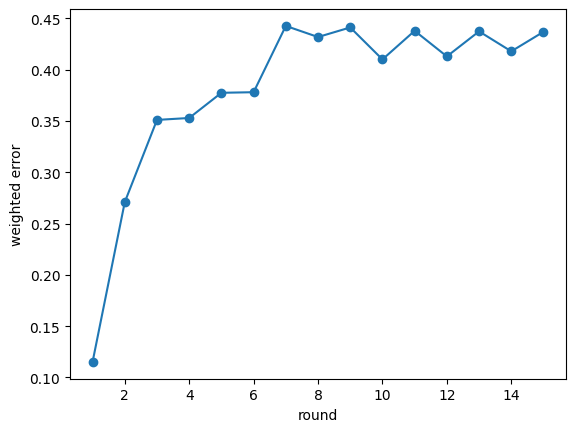

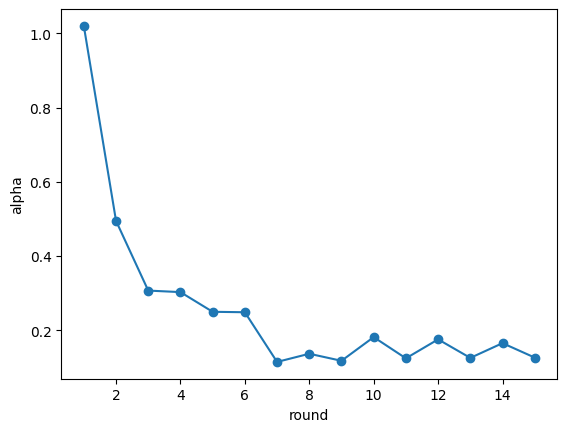

AdaBoost train acc: 0.9187794480592326
AdaBoost test  acc: 0.9282511210762332
Confusion:
 [[957   9]
 [ 71  78]]


In [23]:
import matplotlib.pyplot as plt

T = 15
n = X_tr.shape[0]
w = np.ones(n) / n

clfs = []
a_list = []
err_list = []

for t in range(1, T+1):
    h = DecisionTreeClassifier(max_depth=1, random_state=t)
    h.fit(X_tr, y_tr, sample_weight=w)
    y_h = h.predict(X_tr)

    miss = (y_h != y_tr).astype(int)
    e = np.dot(w, miss) / w.sum()

    # avoid zero / one
    e = np.clip(e, 1e-10, 1-1e-10)
    a = 0.5 * np.log((1-e) / e)


    bad_idx = np.where(miss == 1)[0]
    print(f"\nRound {t}")
    print("Wrong idx:", bad_idx[:20])
    print("Wrong w :", w[bad_idx][:10])
    print("alpha   :", a)


    w = w * np.exp(a * miss * 2 - a*2)
    w = w / w.sum()

    clfs.append(h)
    a_list.append(a)
    err_list.append(e)


plt.plot(range(1, T+1), err_list, marker="o")
plt.xlabel("round")
plt.ylabel("weighted error")
plt.show()

plt.plot(range(1, T+1), a_list, marker="o")
plt.xlabel("round")
plt.ylabel("alpha")
plt.show()


def strong_pred(X):
    s = np.zeros(X.shape[0])
    for a, h in zip(a_list, clfs):
        s += a * h.predict(X)
    return (s >= 0.5 * sum(a_list)).astype(int)

y_tr_f = strong_pred(X_tr)
y_te_f = strong_pred(X_te)

print("AdaBoost train acc:", accuracy_score(y_tr, y_tr_f))
print("AdaBoost test  acc:", accuracy_score(y_te, y_te_f))
print("Confusion:\n", confusion_matrix(y_te, y_te_f))


In [24]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(

    n_estimators=100,
    learning_rate=0.6,
    random_state=1
)
ada.fit(X_tr, y_tr)

y_tr_s = ada.predict(X_tr)
y_te_s = ada.predict(X_te)

print("Sklearn Ada train acc:", accuracy_score(y_tr, y_tr_s))
print("Sklearn Ada test  acc:", accuracy_score(y_te, y_te_s))
print("Confusion:\n", confusion_matrix(y_te, y_te_s))


Sklearn Ada train acc: 0.9385236706304689
Sklearn Ada test  acc: 0.9372197309417041
Confusion:
 [[963   3]
 [ 67  82]]


Q2. Dataset Description
You will use the UCI Heart Disease dataset (available in sklearn.datasets).
This dataset contains patient medical features used to predict heart disease.
Feature

Meaning

Age

Patient age

Sex

Gender (1 = male, 0 = female)

Cp

Chest pain type (0–3)

Trestbps

Resting blood pressure

Chol

Serum cholesterol (mg/dl)

Fbs

Fasting blood sugar >120 mg/dl (1/0)

Restecg

Resting ECG results

Thalach

Max heart rate achieved

Exang

Exercise-induced angina (1/0)

Oldpeak

ST depression induced by exercise

Slope

Slope of peak exercise ST segment

Ca

# of major vessels (0–3)

Thal

Thallium stress test result (0–3)

Target:
1 = heart disease present
0 = No heart disease

Part A — Baseline Model (Weak Learner)
1. Load the dataset and preprocess (handle categorical features, scaling if needed)
2. Train one Decision Stump (max_depth = 1)
3. Report:
• Training & test accuracy
• Confusion matrix
• Classification report
4. What shortcomings do you observe in a single stump?

Part B — Train AdaBoost
1. Train AdaBoostClassifier using decision stumps as base learners
2. Use:
• n_estimators = [5, 10, 25, 50, 100]
• learning_rate = [0.1, 0.5, 1.0]
3. For each combination:
• Train model
• Compute accuracy on test set
4. Plot:
• n_estimators vs accuracy for each learning_rate
5. Identify best config (highest accuracy)

Part C — Misclassification Pattern
1. For the best model, collect the sample weights and prediction errors at each iteration.
2. Plot:
• Weak learner error vs iteration
• Sample weight distribution after final boosting stage
3. Explain:
• Which samples got highest weights?
• Why does AdaBoost focus on them?

Part D — Visual Explainability
1. Plot feature importance from AdaBoost.
2. Identify top 5 most important features.
3. Explain why these features may matter medically.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Part A
data = fetch_openml(name='heart', version=1, as_frame=True, parser='auto')
df = data.frame
X = df.drop(columns=['target'])
y = df['target'].astype(int)

le = LabelEncoder()
for col in X.select_dtypes(include='category').columns:
    X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(max_depth=1, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print("Part A Results:")
print("Train Acc:", accuracy_score(y_train, y_train_pred))
print("Test Acc:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

# Part B
n_est = [5, 10, 25, 50, 100]
l_rates = [0.1, 0.5, 1.0]
results = []

for lr in l_rates:
    acc_list = []
    for n in n_est:
        ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                 n_estimators=n, learning_rate=lr, random_state=42, algorithm='SAMME')
        ada.fit(X_train, y_train)
        acc = accuracy_score(y_test, ada.predict(X_test))
        acc_list.append(acc)
        results.append((lr, n, acc))

    plt.plot(n_est, acc_list, label=f'LR={lr}')

plt.title("n_estimators vs Accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

best = max(results, key=lambda x: x[2])
print(f"Best Config: LR={best[0]}, n_est={best[1]}, Acc={best[2]}")

# Part C
best_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                              n_estimators=best[1], learning_rate=best[0],
                              random_state=42, algorithm='SAMME')
best_ada.fit(X_train, y_train)

errors = best_ada.estimator_errors_
plt.figure()
plt.plot(range(len(errors)), errors)
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

# Part D
imps = best_ada.feature_importances_
indices = np.argsort(imps)[::-1][:5]
print("Top 5 Features:", X.columns[indices].values)

plt.figure()
plt.title("Feature Importances")
plt.bar(range(5), imps[indices])
plt.xticks(range(5), X.columns[indices])
plt.show()

Q3:WISDM  dataset

Baseline Results:
Acc: 0.652196723323311
CM:
 [[170438  17475]
 [ 95888  42139]]
Iter 1:
Misclassified indices: [ 0  2  4  9 12]
Weights of misclassified: [1.88919494e-06 1.88919494e-06 1.88919494e-06 1.88919494e-06
 1.88919494e-06]
Iter 2:
Misclassified indices: [4 5 6 8 9]
Weights of misclassified: [2.03351701e-06 1.08537381e-06 1.08537381e-06 1.08537381e-06
 2.03351701e-06]
Iter 3:
Misclassified indices: [ 0  2  3  5 11]
Weights of misclassified: [1.96515079e-06 1.96515079e-06 1.04888387e-06 1.20913954e-06
 1.04888387e-06]
Iter 4:
Misclassified indices: [1 4 6 7 8]
Weights of misclassified: [9.53380893e-07 2.05913078e-06 1.09904496e-06 9.53380893e-07
 1.09904496e-06]
Iter 5:
Misclassified indices: [ 0  2  3  5 11]
Weights of misclassified: [1.94648077e-06 1.94648077e-06 1.03891890e-06 1.19765204e-06
 1.03891890e-06]
Iter 6:
Misclassified indices: [1 4 5 6 8]
Weights of misclassified: [9.53213469e-07 2.05876918e-06 1.29997776e-06 1.09885195e-06
 1.09885195e-06]
Iter 7:
Misclassified 

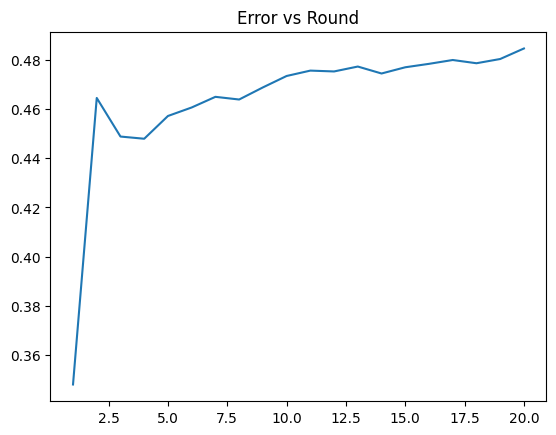

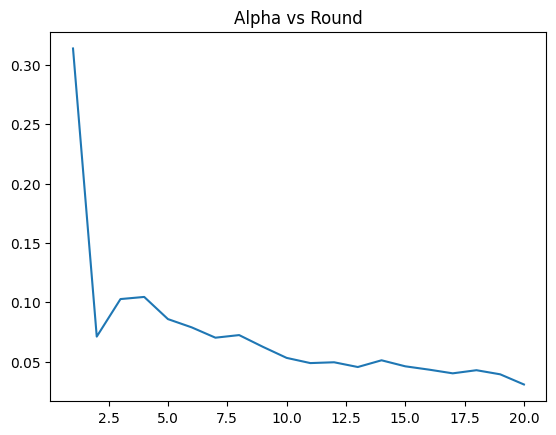

Manual AdaBoost Results:
Train Acc: 0.6946021569282312
Test Acc: 0.6945112597410567
CM:
 [[165670  22243]
 [ 77328  60699]]


KeyboardInterrupt: 

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Part A
cols = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']
df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header=None, names=cols, on_bad_lines='skip')
df['z'] = df['z'].astype(str).str.replace(';', '').astype(float)

df['label'] = df['activity'].apply(lambda x: 1 if x in ['Jogging', 'Upstairs'] else 0)
X = df[['x', 'y', 'z']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Part B
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
base_pred = stump.predict(X_test)

print("Baseline Results:")
print("Acc:", accuracy_score(y_test, base_pred))
print("CM:\n", confusion_matrix(y_test, base_pred))

# Part C - Manual AdaBoost
n_train = len(X_train)
w = np.ones(n_train) / n_train
alphas = []
errors = []
models = []

T = 20
y_train_ada = np.where(y_train == 0, -1, 1)

for t in range(T):
    clf = DecisionTreeClassifier(max_depth=1, random_state=42)
    clf.fit(X_train, y_train, sample_weight=w)
    pred = clf.predict(X_train)
    pred_ada = np.where(pred == 0, -1, 1)

    err = np.sum(w * (pred_ada != y_train_ada))

    alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
    alphas.append(alpha)
    errors.append(err)
    models.append(clf)

    mis = pred_ada != y_train_ada
    w *= np.exp(-alpha * y_train_ada * pred_ada)
    w /= np.sum(w)

    print(f"Iter {t+1}:")
    print("Misclassified indices:", np.where(mis)[0][:5])
    print("Weights of misclassified:", w[mis][:5])

plt.figure()
plt.plot(range(1, T+1), errors)
plt.title("Error vs Round")
plt.show()

plt.figure()
plt.plot(range(1, T+1), alphas)
plt.title("Alpha vs Round")
plt.show()

final_preds = np.zeros(len(X_test))
for alpha, model in zip(alphas, models):
    p = model.predict(X_test)
    p_ada = np.where(p == 0, -1, 1)
    final_preds += alpha * p_ada

final_preds = np.sign(final_preds)
final_preds = np.where(final_preds == -1, 0, 1)

print("Manual AdaBoost Results:")
print("Train Acc:", accuracy_score(y_train, np.where(np.sign(sum(a * np.where(m.predict(X_train)==0,-1,1) for a,m in zip(alphas, models)))==-1,0,1)))
print("Test Acc:", accuracy_score(y_test, final_preds))
print("CM:\n", confusion_matrix(y_test, final_preds))

# Part D
sk_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                            n_estimators=100, learning_rate=1.0, random_state=42)
sk_ada.fit(X_train, y_train)
sk_pred = sk_ada.predict(X_test)

print("Sklearn Results:")
print("Acc:", accuracy_score(y_test, sk_pred))
print("CM:\n", confusion_matrix(y_test, sk_pred))